In [1]:
# %pip install pandas -U
# %pip install --upgrade pandas
# %pip install xlrd -U
import pandas as pd
# %pip install --upgrade xlrd
# %pip install statsmodels -U
# %pip install statsmodels==0.13.0

# Winters
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
import pandas.util.testing as tm
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

### Load Data

In [23]:
# Load the data
years = ['2018','2019','2020','2021']
demands = [pd.read_excel(open('demands.xls', 'rb'), sheet_name=year) for year in years]

### Pre Processing

In [24]:
# Create one dataframe with all the data and add a 'YEAR' column
for i in range(len(years)):
     demands[i]["YEAR"]=int(years[i])
total_demands = pd.concat(demands)

In [25]:
##################### DO NOT DELETE #####################
# active_sku_ids = total_demands[total_demands['YEAR'] == 2021]['SKU_ID'].unique()
# total_demands = total_demands[total_demands['SKU_ID'].isin(active_sku_ids)]

In [26]:
# Load assuta items and remove them from the dataframe
assuta_items = pd.read_excel("Assuta_items.xlsx")
total_demands = total_demands[~total_demands["SKU_ID"].isin(assuta_items["SKU_ID"])].copy()

4798    2FK32753
6767    3L000351
5797    TAR10621
146     2O422003
2982    2OK52810
          ...   
3846    MP107310
4802    AB728029
8588    RAK00001
1091    C2237002
5821    0LK00512
Name: SKU_ID, Length: 267, dtype: object

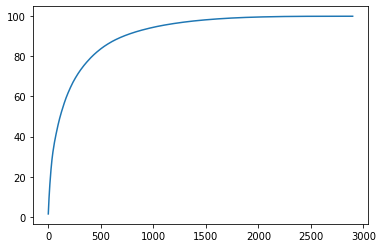

In [27]:
# Group A - find the ~20% with highest demands
# for every product, calculate the average demand for the 4 years
import matplotlib.pyplot as plt
data_b = total_demands.copy()
annual_avg = ((data_b.groupby("SKU_ID")["TOTAL_FOR_YEAR"].mean())).to_frame()
annual_avg.columns = ['YEARLY_AVG']
annual_avg.reset_index(inplace=True)
# annual_avg.head()
data_c = total_demands.copy()
data_merged = pd.merge(data_c, annual_avg, how='inner', on = 'SKU_ID')
good_sku_ids = data_merged[["SKU_ID", "YEARLY_AVG"]].drop_duplicates().sort_values(by=['YEARLY_AVG'], ascending=False)
# a.reset_index(inplace=True)
# a.to_csv(r'good_sku_ids.csv', index = False)
good_sku_ids['CUMSUM'] = good_sku_ids['YEARLY_AVG'].cumsum()
good_sku_ids['CUMSUM_PERC'] = 100*good_sku_ids['CUMSUM']/good_sku_ids['YEARLY_AVG'].sum()
plt.plot(np.arange(len(good_sku_ids['CUMSUM_PERC'])),good_sku_ids['CUMSUM_PERC'])
good_sku_ids['Up_To'] = good_sku_ids['CUMSUM_PERC'] < 70
good_sku_ids = good_sku_ids[good_sku_ids['Up_To']]
a_list_sku_ids = good_sku_ids['SKU_ID']
a_list_sku_ids

In [28]:
total_demands = total_demands[total_demands["SKU_ID"].isin(list(a_list_sku_ids))].copy()

In [29]:
# Fill Nulls with 0.1
total_demands.fillna(0.1,inplace=True)

In [30]:
total_demands

,SKU_ID,'01','02','03','04','05','06','07','08','09','10','11','12',TOTAL_FOR_YEAR,AVG_PER_MONTH,TRIGGER_QTY,MAXIMUM_QTY,QTY_ON_HAND,YEAR
1,14571184,12141.0,11562.0,10361.0,13413.0,9324.0,12707.0,8893.0,8776.0,7812.0,15865.0,17097.0,17987.0,145938,12161.5,1152.0,2304,1104,2018
6,2BK42310,5902.0,3750.0,4081.0,4226.0,3872.0,4380.0,3775.0,6354.0,8681.0,4705.0,4165.0,4460.0,58351,4862.6,880.0,1760,1704,2018
7,3CK01011,9634.0,9173.0,6885.0,8021.0,10504.0,7689.0,7958.0,8866.0,6617.0,7619.0,8736.0,7707.0,99409,8284.1,560.0,840,593,2018
8,BI000209,2182.0,1998.0,1409.0,2436.0,1073.0,2201.0,3089.0,1928.0,2583.0,2431.0,2008.0,2611.0,25949,2162.4,780.0,1560,1006,2018
14,2CK05910,14401.0,10721.0,11362.0,12671.0,11809.0,9266.0,12824.0,5583.0,11990.0,13829.0,13831.0,9414.0,137701,11475.1,1440.0,2880,655,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,RAK00012,0.1,0.1,0.1,0.1,9467.0,2796.0,2418.0,14144.0,3270.0,4954.0,5648.0,6943.0,49640,4136.7,800.0,2000,1278,2021
2937,BI000251,11240.0,4576.0,5255.0,5701.0,3219.0,21.0,78.0,105.0,38.0,148.0,109.0,96.0,30586,2548.8,240.0,480,810,2021
2956,ACTAV042,0.1,0.1,0.1,0.1,0.1,0.1,0.1,9055.0,1814.0,4563.0,3408.0,4044.0,22884,1907.0,256.0,512,434,2021
2977,ULM00178,0.1,0.1,0.1,0.1,4020.0,4167.0,5215.0,5726.0,2037.0,3505.0,3276.0,3429.0,31375,2614.6,600.0,1200,756,2021


In [31]:
# Add quarters columns
total_demands["P1"] = total_demands["'01'"] + total_demands["'02'"]
total_demands["P2"] = total_demands["'03'"] + total_demands["'04'"]
total_demands["P3"] = total_demands["'05'"] + total_demands["'06'"]
total_demands["P4"] = total_demands["'07'"] + total_demands["'08'"]
total_demands["P5"] = total_demands["'09'"] + total_demands["'10'"]
total_demands["P6"] = total_demands["'11'"] + total_demands["'12'"]

# Add quarters columns
total_demands["Q1"] = total_demands["'01'"] + total_demands["'02'"] + total_demands["'03'"]
total_demands["Q2"] = total_demands["'04'"] + total_demands["'05'"] + total_demands["'06'"]
total_demands["Q3"] = total_demands["'07'"] + total_demands["'08'"] + total_demands["'09'"]
total_demands["Q4"] = total_demands["'10'"] + total_demands["'11'"] + total_demands["'12'"]

In [32]:
total_demands

,SKU_ID,'01','02','03','04','05','06','07','08','09',...,P1,P2,P3,P4,P5,P6,Q1,Q2,Q3,Q4
1,14571184,12141.0,11562.0,10361.0,13413.0,9324.0,12707.0,8893.0,8776.0,7812.0,...,23703.0,23774.0,22031.0,17669.0,23677.0,35084.0,34064.0,35444.0,25481.0,50949.0
6,2BK42310,5902.0,3750.0,4081.0,4226.0,3872.0,4380.0,3775.0,6354.0,8681.0,...,9652.0,8307.0,8252.0,10129.0,13386.0,8625.0,13733.0,12478.0,18810.0,13330.0
7,3CK01011,9634.0,9173.0,6885.0,8021.0,10504.0,7689.0,7958.0,8866.0,6617.0,...,18807.0,14906.0,18193.0,16824.0,14236.0,16443.0,25692.0,26214.0,23441.0,24062.0
8,BI000209,2182.0,1998.0,1409.0,2436.0,1073.0,2201.0,3089.0,1928.0,2583.0,...,4180.0,3845.0,3274.0,5017.0,5014.0,4619.0,5589.0,5710.0,7600.0,7050.0
14,2CK05910,14401.0,10721.0,11362.0,12671.0,11809.0,9266.0,12824.0,5583.0,11990.0,...,25122.0,24033.0,21075.0,18407.0,25819.0,23245.0,36484.0,33746.0,30397.0,37074.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,RAK00012,0.1,0.1,0.1,0.1,9467.0,2796.0,2418.0,14144.0,3270.0,...,0.2,0.2,12263.0,16562.0,8224.0,12591.0,0.3,12263.1,19832.0,17545.0
2937,BI000251,11240.0,4576.0,5255.0,5701.0,3219.0,21.0,78.0,105.0,38.0,...,15816.0,10956.0,3240.0,183.0,186.0,205.0,21071.0,8941.0,221.0,353.0
2956,ACTAV042,0.1,0.1,0.1,0.1,0.1,0.1,0.1,9055.0,1814.0,...,0.2,0.2,0.2,9055.1,6377.0,7452.0,0.3,0.3,10869.1,12015.0
2977,ULM00178,0.1,0.1,0.1,0.1,4020.0,4167.0,5215.0,5726.0,2037.0,...,0.2,0.2,8187.0,10941.0,5542.0,6705.0,0.3,8187.1,12978.0,10210.0


### Winters Model

In [65]:
# def seasonality (demand_series,seasonal_periods):
#     fit = ExponentialSmoothing(demand_series,seasonal_periods=seasonal_periods,trend="add",
#                                 seasonal="mul",use_boxcox=True,initialization_method="estimated").fit(use_brute=True,optimized=True,remove_bias=True)
#     # fit = ExponentialSmoothing(demand_series,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit(smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5)
#     results = pd.DataFrame(index=["\u03B1", "\u03B2", "\u03B3", "\u03C6", "l_0", "b_0", "SSE"])   
#     params = ["smoothing_level","smoothing_trend","smoothing_seasonal","damping_trend","initial_level","initial_trend"]
#     results["Multiplica Dam"] = [fit.params[p] for p in params] + [fit.sse]
#     df = pd.DataFrame(np.c_[aust, fit.level, fit.trend, fit.season, fit.fittedvalues], columns=['Y_t', 'L_t', 'B_t', 'S_t', 'Y_t_hat'],index=aust.index)
#     return pd.concat([df['S_t'].iloc[:seasonal_periods],df['B_t'].iloc[:1]]).to_numpy()

# # data = [10,40,11,100,20,30,20,30,15,120,40,50]
# # index = pd.date_range(start="2005", end="2017", freq="Y")
# # aust = pd.Series(data, index)
# # print(seasonality(aust,4))

In [84]:
def seasonality (demand_series,seasonal_periods):
    fit1 = ExponentialSmoothing(demand_series,seasonal_periods=seasonal_periods,trend="add",
                                seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
    # fit = ExponentialSmoothing(demand_series,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit(smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5)
    results = pd.DataFrame(index=["\u03B1", "\u03B2", "\u03B3", "\u03C6", "l_0", "b_0", "SSE"])   
    params = ["smoothing_level","smoothing_trend","smoothing_seasonal","damping_trend","initial_level","initial_trend"]
    results["Multiplica Dam"] = [fit1.params[p] for p in params] + [fit1.sse]
    fit2 = ExponentialSmoothing(demand_series,seasonal_periods=seasonal_periods,trend="add",
                                seasonal="mul",initialization_method="estimated").fit()
    # fit = ExponentialSmoothing(demand_series,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,initialization_method="estimated").fit(smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5)
    df = pd.DataFrame(np.c_[aust, fit2.level, fit2.trend, fit2.season, fit2.fittedvalues], columns=['Y_t', 'L_t', 'B_t', 'S_t', 'Y_t_hat'],index=aust.index)
    # df.append(fit.forecast(8).rename(r"$/hat{y}_t$").to_frame(), sort=True)
    # a = pd.concat(df,df, ignore_index=True)
    return pd.concat([df['S_t'].iloc[:seasonal_periods],df['B_t'].iloc[:1]]).to_numpy()

data = [10,40,11,100,20,30,20,30,15,120,40,50]
index = pd.date_range(start="2005", end="2017", freq="Y")
aust = pd.Series(data, index)
print(seasonality(aust,4))

[0.42263126 1.80806407 0.62942794 1.27163634 2.56752112]


In [85]:
unique_sku_ids = total_demands['SKU_ID'].unique()
v_list = []
for i,k in tqdm(enumerate(unique_sku_ids)):
    data = total_demands[total_demands['SKU_ID'] == k].iloc[:,19:25].to_numpy().reshape(-1)
    try:
        index = np.arange(len(data))
        aust = pd.Series(data, index)
        vector = seasonality(aust,6)
    except ValueError:
        new_data = np.concatenate([data, data])
        index = np.arange(len(new_data))
        aust = pd.Series(new_data, index)
        vector = seasonality(aust,6)
    v_list.append(vector)
df1 = pd.DataFrame(unique_sku_ids,columns=['SKU_ID'])
# df2 = pd.DataFrame(v_list,columns=['C1','C2','C3','C4','trend'])
df2 = pd.DataFrame(v_list,columns=['C1','C2','C3','C4','C5','C6','trend'])
df3 = pd.concat([df1,df2],axis=1)

267it [01:09,  3.87it/s]


In [88]:
df3.to_csv('seasonality_6_small.csv',index=False)
# df3[df3['C3']<0]

In [89]:
seasonality = pd.read_csv('seasonality_4_small.csv')
seasonality

# seasonality = df3.copy()
# seasonality[seasonality['SKU_ID']=='ULM00073']

,SKU_ID,C1,C2,C3,C4,trend
0,14571184,0.851989,1.025192,0.802074,1.320736,-2.256390e+02
1,2BK42310,0.970235,1.004707,1.002351,1.022655,1.529834e+03
2,3CK01011,0.959594,1.054309,1.034656,1.063917,-2.216946e+03
3,BI000209,1.172852,0.768438,1.090347,0.968376,4.193981e+01
4,2CK05910,1.317194,0.957138,0.828475,0.897150,2.007119e+03
...,...,...,...,...,...,...
262,RAK00012,0.000024,0.988155,1.598053,1.413768,0.000000e+00
263,BI000251,2.755640,1.169293,0.028902,0.046165,2.457504e-12
264,ACTAV042,0.000052,0.000052,1.899802,2.100093,0.000000e+00
265,ULM00178,0.000038,1.043760,1.654545,1.301657,0.000000e+00


In [90]:
# Load the data set
seasonality = pd.read_csv('seasonality_4_small.csv')
# Normalize the seasonaluty values (sum up to  1)
seasonality.iloc[:,1:5] = seasonality.iloc[:,1:5].apply(lambda row: row/np.sum(row,axis=0), axis=1)
# Add 'STDV' column (stdv of seasonality values)
seasonality['STDV'] = np.std(seasonality.iloc[:,1:5].to_numpy(),axis=1)
seasonality.sort_values(by=['STDV'],inplace=True)
# Normalize the trend values 
# from sklearn.preprocessing import StandardScaler
# for column in seasonality.columns:
#   if column == 'trend':
#     scale= StandardScaler()
#     seasonality[column] = scale.fit_transform(seasonality[column].to_numpy().reshape(-1, 1))
# Reset indexes
seasonality.reset_index(inplace=True)
# Display every 100th index
# idxes_list = list(seasonality.index)[0::200]
# seasonality_partly = seasonality[seasonality.index.isin(idxes_list)]
# # seasonality_partly_4 = list(seasonality_partly['index'])
seasonality

,index,SKU_ID,C1,C2,C3,C4,trend,STDV
0,74,I1357593,0.252269,0.249143,0.252375,0.246213,482.717115,0.002543
1,1,2BK42310,0.242562,0.251180,0.250591,0.255667,1529.834078,0.004722
2,219,MP034163,0.259975,0.248639,0.244637,0.246750,-25.474041,0.005930
3,224,GS884343,0.257318,0.245853,0.242365,0.254464,-321.702577,0.006103
4,185,TAR10942,0.242730,0.259407,0.245750,0.252113,1105.929263,0.006400
...,...,...,...,...,...,...,...,...
262,236,RB201345,0.000027,0.000020,0.000016,0.999937,2691.679904,0.432976
263,242,ULM00180,0.000025,0.000015,0.000011,0.999949,13279.062110,0.432983
264,253,BI286263,0.000015,0.000013,0.999962,0.000010,1722.805389,0.432991
265,234,RB200941,0.000011,0.000010,0.000009,0.999970,1211.936894,0.432995


In [91]:
sku = 'ULM00073'

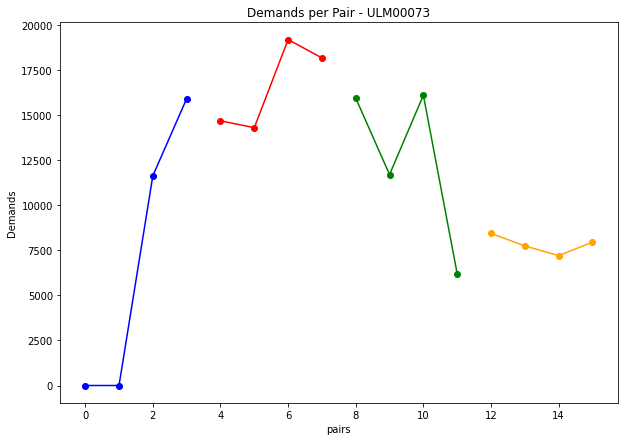

In [92]:
def plot_graph_4(sku_id):
  data = total_demands[total_demands['SKU_ID'] == sku_id].iloc[:,25:].to_numpy().reshape(-1)
  index = np.arange(len(data))
  aust = pd.Series(data, index)
  try:
    fit = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit(use_brute=True,remove_bias=True)
    fcast1 = fit.forecast(12)
  except ValueError:
    print('Double')
    new_data = np.concatenate([data, data])
    index = np.arange(len(new_data))
    aust = pd.Series(new_data, index)
    fit = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit(use_brute=True,remove_bias=True)
    fcast1 = fit.forecast(12)
  d=0
  dic = {0:"blue", 1:"red", 2:"green", 3:"orange", 4:"purple", 5:"yellow"}
  for i in range(int(len(aust)/4)):
    ax = aust[d:d+4].plot(figsize=(10, 7),marker="o",color=dic[i],title=f'Demands per Pair - {sku_id}')
    d += 4
  # fcast1.plot(ax=ax, color="black", marker="o", legend=False)
  ax.set_ylabel("Demands")
  ax.set_xlabel("pairs")
  # path = f'{sku_id}.png'
  # plt.savefig(path)
plot_graph_4(sku)

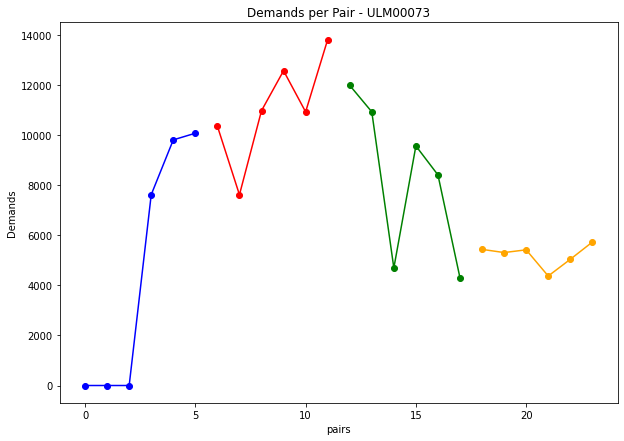

In [93]:
def plot_graph_6(sku_id):
  data = total_demands[total_demands['SKU_ID'] == sku_id].iloc[:,19:25].to_numpy().reshape(-1)
  index = np.arange(len(data))
  aust = pd.Series(data, index)
  try:
    fit = ExponentialSmoothing(aust,seasonal_periods=6,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit(use_brute=True,remove_bias=True)
    fcast1 = fit.forecast(12)
  except ValueError:
    print('Double')
    new_data = np.concatenate([data, data])
    index = np.arange(len(new_data))
    aust = pd.Series(new_data, index)
    fit = ExponentialSmoothing(aust,seasonal_periods=6,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit(use_brute=True,remove_bias=True)
    fcast1 = fit.forecast(12)
  d=0
  dic = {0:"blue", 1:"red", 2:"green", 3:"orange", 4:"purple", 5:"yellow"}
  for i in range(int(len(aust)/6)):
    ax = aust[d:d+6].plot(figsize=(10, 7),marker="o",color=dic[i],title=f'Demands per Pair - {sku_id}')
    d += 6
  # fcast1.plot(ax=ax, color="black", marker="o", legend=False)
  ax.set_ylabel("Demands")
  ax.set_xlabel("pairs")
  # path = f'{sku_id}.png'
  # plt.savefig(path)
plot_graph_6(sku)

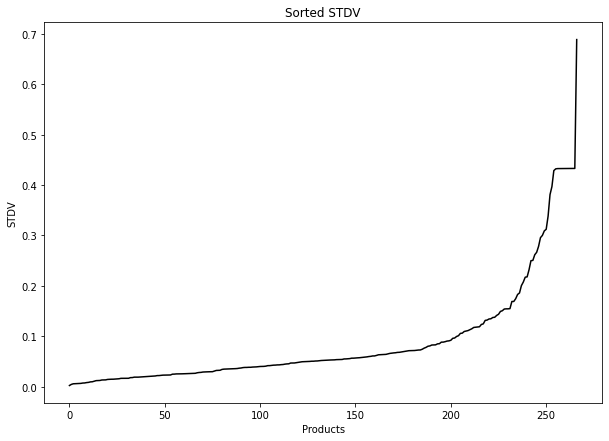

In [100]:
def plot_STDV(seasonality):
  data = seasonality.iloc[:267,:]['STDV'].to_numpy().reshape(-1)
  index = np.arange(len(data))
  aust = pd.Series(data, index)
  ax = aust.plot(figsize=(10, 7),color="black",title=f'Sorted STDV')
  ax.set_ylabel("STDV")
  ax.set_xlabel("Products")
  # path = f'{sku_id}.png'
  # plt.savefig(path)
plot_STDV(seasonality)

In [68]:
# from sklearn.preprocessing import StandardScaler
# for column in seasonality.columns:
#   if column == 'trend':
#     scale= StandardScaler()
#     seasonality[column] = scale.fit_transform(seasonality[column].to_numpy().reshape(-1, 1))
# seasonality

In [69]:
# def plot_graph(sku_id):
#   data = total_demands[total_demands['SKU_ID'] == sku_id].iloc[:,19:].to_numpy().reshape(-1)
#   index = np.arange(len(data))
#   aust = pd.Series(data, index)
#   # data = [10,40,110,100,202,303,1000,1100]
#   # index = pd.date_range(start="2005", end="2013", freq="Y")
#   # aust = pd.Series(data, index)
#   fit = ExponentialSmoothing(aust,seasonal_periods=6,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
#   fcast1 = fit.forecast(12)
#   print(data)
#   print(fcast1)
#   ax = aust.plot(figsize=(10, 7),marker="o",color="blue",title=f'Demands per Pair - {sku_id}')
#   fcast1.plot(ax=ax, color="black", marker="o", legend=False)
#   ax.set_ylabel("Demands")
#   ax.set_xlabel("Quarters")
#   path = f'{sku_id}.png'
#   plt.savefig(path)

# plot_graph('FC42561N')

In [240]:
np.random.seed(42)
data = seasonality.iloc[:,2:-1].to_numpy()
# pca = PCA(n_components=3)
# components = pca.fit_transform(data)
tsne = TSNE(n_components=2, perplexity=50)
components = tsne.fit_transform(data)
# components = data
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(components)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = seasonality.index.values
cluster_map['cluster'] = kmeans.labels_# fig, ax = plt.subplots(figsize=(20, 10))
cluster_map['cluster'].value_counts()

1    1655
0    1243
Name: cluster, dtype: int64

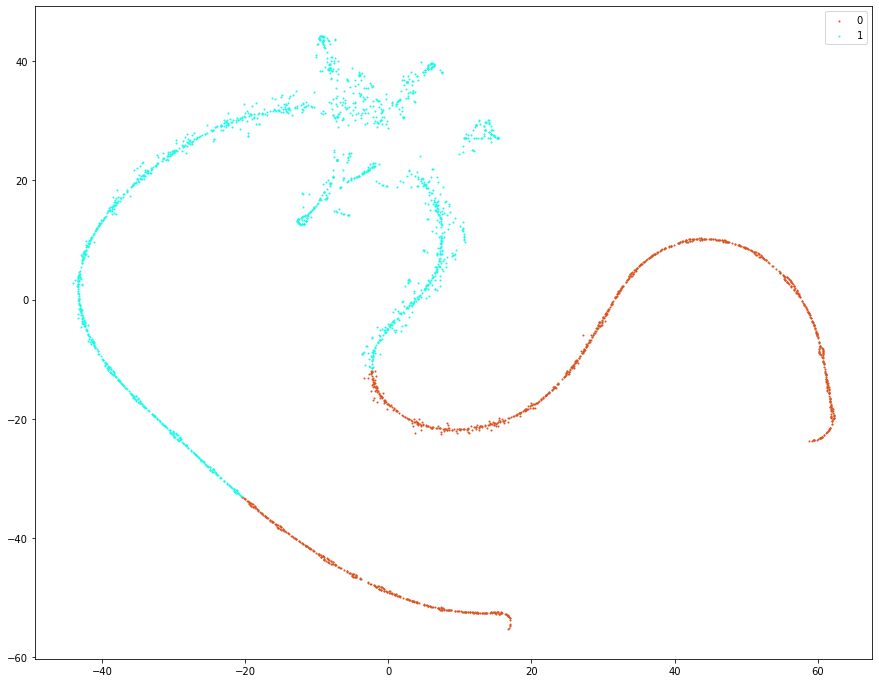

In [244]:
colors = [np.array([random.sample(range(0,255),3)])/255 for i in range(n_clusters)]
fig, ax = plt.subplots(figsize=(15, 12))
for i in range(n_clusters):
    ax.scatter(components[kmeans.labels_==i][:,0],
            components[kmeans.labels_==i][:,1],
            color=colors[i],s=1,label=f'{i}')
    ax.legend()

In [245]:
seasonality_6 = pd.read_csv('seasonality_6.csv')
cluster_2_idxes = cluster_map[cluster_map['cluster'] == 0]['data_index']
a = seasonality_6.iloc[cluster_2_idxes,:]
print((a['trend']==0).sum())
a

86


,SKU_ID,C1,C2,C3,C4,C5,C6,trend
0,NU802536,1.261633,1.023050,1.050444,1.070084,1.161664,1.141048,-9.002726e+01
2,RB038125,1.557682,1.446237,2.453857,1.002657,0.949606,1.624795,-1.633005e+01
5,DS095617,1.001525,1.200850,1.393325,0.839860,1.365593,1.054871,9.855665e-01
6,2BK42310,1.054908,0.897601,1.003455,1.023324,0.965998,1.054646,8.233615e+02
8,BI000209,1.164451,0.844396,0.857652,1.166371,0.959928,1.007246,-4.370707e+02
...,...,...,...,...,...,...,...,...
2889,DM942529,0.000043,2.170718,2.418177,0.000043,0.000043,1.410974,0.000000e+00
2892,RB572870,0.001191,0.001191,0.001191,3.138150,2.036522,0.821755,3.248610e-12
2895,SQ336060,0.026608,0.026608,0.026608,0.026608,0.026608,5.866962,0.000000e+00
2896,0SK00441,0.066298,0.066298,0.066298,0.066298,0.066298,5.668508,0.000000e+00


In [ ]:
cluster_map['cluster'].value_counts()

0    524
3    442
5    392
2    371
6    339
7    304
4    271
1    255
Name: cluster, dtype: int64

In [ ]:
fit1 = SimpleExpSmoothing(livestock2, initialization_method="estimated").fit()
fcast1 = fit1.forecast(9).rename("SES")
fit2 = Holt(livestock2, initialization_method="estimated").fit()
fcast2 = fit2.forecast(9).rename("Holt's")
fit3 = Holt(livestock2, exponential=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(9).rename("Exponential")
fit4 = Holt(livestock2, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fcast4 = fit4.forecast(9).rename("Additive Damped")
fit5 = Holt(
    livestock2, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
fcast5 = fit5.forecast(9).rename("Multiplicative Damped")

ax = livestock2.plot(color="black", marker="o", figsize=(12, 8))
livestock3.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color="red", legend=True)
fcast2.plot(ax=ax, color="green", legend=True)
fcast3.plot(ax=ax, color="blue", legend=True)
fcast4.plot(ax=ax, color="cyan", legend=True)
fcast5.plot(ax=ax, color="magenta", legend=True)
ax.set_ylabel("Livestock, sheep in Asia (millions)")
plt.show()

NameError: ignored

In [ ]:
aust = np.array([2,3,10,11,1,4,11,10,3,2])
fit1 = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="add",use_boxcox=True,initialization_method="estimated",).fit()
fit2 = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated",).fit()
fit3 = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,initialization_method="estimated",).fit()
fit4 = ExponentialSmoothing(aust,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated",).fit()
results = pd.DataFrame(index=[r"$/alpha$", r"$/beta$", r"$/phi$", r"$/gamma$", r"$l_0$", "$b_0$", "SSE"])
params = ["smoothing_level","smoothing_trend","damping_trend","smoothing_seasonal","initial_level","initial_trend",]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

# ax = aust.plot(figsize=(10, 6),marker="o",color="black",title="Forecasts from Holt-Winters' multiplicative method",)
# ax.set_ylabel("International visitor night in Australia (millions)")
# ax.set_xlabel("Year")
# fit1.fittedvalues.plot(ax=ax, style="--", color="red")
# fit2.fittedvalues.plot(ax=ax, style="--", color="green")

# fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style="--", marker="o", color="red", legend=True)
# fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="green", legend=True)

# plt.show()
# print("Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.")

results

In [ ]:
# %pip install statsmodels
# import statsmodels.api
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)
a=[5.5,5.625,5.5,9.05,5.175,5.4,4.95,8.25,4.775,4.825]
# b = ExponentialSmoothing(a,trend='mul',seasonal='mul',seasonal_periods=4,initialization_method="estimated").fit()
# # initial_values(a)
# print(ExponentialSmoothing.initial_values(b))

In [ ]:
fit = ExponentialSmoothing(a, seasonal_periods=4, trend='mul', seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(5, repetitions=100, error='mul')
fit.fittedvalues.plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
fit.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

In [ ]:
airline[‘HWES3_MUL’] = ExponentialSmoothing(airline[‘Thousands of Passengers’],trend=’mul’,seasonal=’mul’,
                                            seasonal_periods=12).fit().
fittedvalues
airline[[‘Thousands of Passengers’,’HWES3_ADD’,’HWES3_MUL’]].plot(title=’Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality’);

In [ ]:
# a=list(total_demands["SKU_ID"])
# for i in a:
#     if "AS" in str(i):
#         print(i)

In [ ]:
# Group A - find the ~20% with highest demands
# for every product, calculate the average demand for the 4 years
annual_avg = ((total_demands.groupby("SKU_ID")["TOTAL_FOR_YEAR"].sum())/4).to_frame()
annual_avg.columns = ['YEARLY_AVG']
annual_avg.reset_index(inplace=True)
# annual_avg.head()

In [ ]:
annual_avg